<center><h1>Modelling</h1></center>

TSG Salt Identification Challenge: https://www.kaggle.com/c/tgs-salt-identification-challenge/overview<br>

   According to the research paper of the 1st place solution(refered in the abstract) as well as various articles on the internet, the model most people preffered using was U-Net, obviously with various minute modifications. Modifications were as follows:
   

- Use of Residual blocks as encoders in UNET. This makes the abbreviation UNET into U-ResNet
- Use of ScSe blocks after every Residual block.
- Use of FPA block
- Modification in the Residual blocks in U-ResNet, which makes U-ResNet into U-ResNeXt34/U-ResNeXt50 depending on the number of channels.
- Use of Hypercolumns after decoders

I tried to implement all these changes in this notebook

In [ ]:
#importing libraries
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import tensorflow.keras
import imgaug.augmenters as iaa
import datetime
import sklearn.model_selection
%load_ext tensorboard
from google.colab import files
import os
import sys
import random
import numpy as np
import cv2

from glob import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, MaxPooling2D, GlobalMaxPool2D, Conv2D, Conv2DTranspose, concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Dense,add, Permute, Conv2D,multiply
from tensorflow.keras import backend as K

#evaluation metric
iou_score=tf.keras.metrics.BinaryIoU()

#reading .csv file produced in EDA
data=pd.read_csv("dataset.csv")

In [ ]:
#credit
#https://github.com/ybabakhin/kaggle_salt_bes_phalanx/
def Kaggle_IoU_Precision(y_true, y_pred, threshold=0.5):
    y_pred = K.squeeze(tf.cast((y_pred > threshold),tf.int32), -1)
    y_true = K.cast(y_true[..., 0], K.floatx())
    y_pred = K.cast(y_pred, K.floatx())
    truth_areas = K.sum(y_true, axis=[1, 2])
    pred_areas = K.sum(y_pred, axis=[1, 2])
    intersection = K.sum(y_true * y_pred, axis=[1, 2])
    union = K.clip(truth_areas + pred_areas - intersection, 1e-9, 128 * 128)
    check = K.map_fn(lambda x: K.equal(x, 0), truth_areas + pred_areas, dtype=tf.bool)
    p = intersection / union
    iou = K.switch(check, p + 1., p)

    prec = K.map_fn(lambda x: K.mean(K.greater(x, np.arange(0.5, 1.0, 0.05))), iou, dtype=tf.float32)
    prec_iou = K.mean(prec)
    return prec_iou
    
kaggle_iou_score=Kaggle_IoU_Precision
iou_score=tf.keras.metrics.BinaryIoU()

In [ ]:
#splitting the data
train,validation=sklearn.model_selection.train_test_split(data,test_size=0.1)

# MODEL 1: SE-U-ResNxt34

## Image Data Generator


In [4]:
#datagenerator
def random_in_range(lower_limit,upper_limit):
    number=lower_limit+(np.random.rand(1)[0]*(upper_limit-lower_limit))
    return number

def clean_mask(arr):
    temp=np.nonzero(arr)
        
    for i in range(temp[0].shape[0]):
        arr[temp[0][i],temp[1][i]]=1
    return arr


class Dataset:
    # the parameters needs to changed based on your requirements
    # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
    # ex: fil_name.jpg   file_name.mask.jpg
    def __init__(self, file_path,mask_path):
        
        self.iids = file_path
        self.mids = mask_path

        # the paths of images
        self.images_fps   = [i for i in self.iids]
        # the paths of segmentation images
        self.masks_fps    = [i for i in self.mids]
        # giving labels for each class

    def __getitem__(self, i):
        
        # read data
        image=cv2.imread(self.images_fps[i],cv2.IMREAD_GRAYSCALE)
        image_mask = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
        
        a = np.random.uniform()
        if a<0.25:
            True
        elif a<0.50:
            aug = iaa.Fliplr(1)
            image,image_mask=aug.augment(images=[image,image_mask])
        elif a<0.75:
            aug = iaa.Flipud(1)
            image,image_mask=aug.augment(images=[image,image_mask])
        else:
            aug=iaa.GammaContrast(random_in_range(0.5, 2.0))
            image,image_mask=aug.augment(images=[image,image_mask])
            
        image = cv2.copyMakeBorder(image, 13, 14, 13, 14, cv2.BORDER_CONSTANT,value=[0,0,0])
        image_mask = cv2.copyMakeBorder(image_mask,13, 14, 13, 14, cv2.BORDER_CONSTANT,value=[0,0,0])

        image = cv2.resize(image,(256,256),interpolation=cv2.INTER_NEAREST)
        image_mask = cv2.resize(image_mask,(256,256),interpolation=cv2.INTER_NEAREST)

        image_mask=clean_mask(image_mask)
        
        
        return np.expand_dims(image,-1), np.expand_dims(image_mask,-1)
        
    def __len__(self):
        return len(self.iids)
       
class Test_Dataset:
    # the parameters needs to changed based on your requirements
    # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
    # ex: fil_name.jpg   file_name.mask.jpg
    def __init__(self, file_path,mask_path):
        
        self.iids = file_path
        self.mids = mask_path

        # the paths of images
        self.images_fps   = [i for i in self.iids]
        # the paths of segmentation images
        self.masks_fps    = [i for i in self.mids]
        # giving labels for each class

    def __getitem__(self, i):
        
        # read data
        image=cv2.imread(self.images_fps[i],cv2.IMREAD_GRAYSCALE)
        image_mask = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)

        image = cv2.copyMakeBorder(image, 13, 14, 13, 14, cv2.BORDER_CONSTANT,value=[0,0,0])
        image_mask = cv2.copyMakeBorder(image_mask,13, 14, 13, 14, cv2.BORDER_CONSTANT,value=[0,0,0])

        image = cv2.resize(image,(256,256),interpolation=cv2.INTER_NEAREST)
        image_mask = cv2.resize(image_mask,(256,256),interpolation=cv2.INTER_NEAREST)
        
        image_mask=clean_mask(image_mask)
        
        return np.expand_dims(image,-1), np.expand_dims(image_mask,-1)
        
    def __len__(self):
        return len(self.iids)
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

train_dataset = Dataset(train['img_path'],train['mask_path'])
val_dataset = Test_Dataset(validation['img_path'],validation['mask_path'])

train_dataloader = Dataloder(train_dataset, batch_size=10, shuffle=True)
val_dataloader = Dataloder(val_dataset, batch_size=10, shuffle=False)

print(train_dataloader[0][0].shape)
print(val_dataloader[0][0].shape)

(10, 256, 256, 1)
(10, 256, 256, 1)


# Modification Blocks

In [ ]:
#https://arxiv.org/pdf/1805.10180.pdf
class fpa_block(tf.keras.layers.Layer):
    def __init__(self,name="fpe_block"):
        super().__init__(name=name)
        self.GAP=GlobalAveragePooling2D()#keepdims=True)
        self.conv1=Conv2D(128, (1, 1), activation='relu', kernel_initializer = 'he_normal')
        
        self.bn=BatchNormalization()
        self.bn1=BatchNormalization()
        self.bn2=BatchNormalization()
        self.bn3=BatchNormalization()
        self.bn4=BatchNormalization()
        self.bn5=BatchNormalization()
        self.bn6=BatchNormalization()
        self.bn7=BatchNormalization()
        self.bn8=BatchNormalization()
        
        self.upsample=tf.keras.layers.UpSampling2D(size=(8, 8),interpolation="nearest")
        self.conv2=Conv2D(128, (1, 1), activation='relu')
        
        self.fpa3conv71=Conv2D(16, (7, 7), padding="same",activation='relu', kernel_initializer = 'he_normal')
        self.fpa3conv72=Conv2D(128, (7, 7), padding="same",activation='relu', kernel_initializer = 'he_normal')
        self.fpa3conv51=Conv2D(16, (5, 5), padding="same",activation='relu', kernel_initializer = 'he_normal')
        self.fpa3conv52=Conv2D(128, (5, 5), padding="same",activation='relu', kernel_initializer = 'he_normal')
        self.fpa3conv31=Conv2D(16, (3, 3), padding="same",activation='relu', kernel_initializer = 'he_normal')
        self.fpa3conv32=Conv2D(128, (3, 3), padding="same",activation='relu', kernel_initializer = 'he_normal')
    

    def call(self, X):
        # write the architecutre that was mentioned above
        X=self.bn(X)

        fpa1=self.GAP(X)
        fpa1=tf.expand_dims(fpa1,1)
        fpa1=tf.expand_dims(fpa1,1)

        fpa1 =self.conv1(fpa1)
        fpa1=self.bn1(fpa1)
        fpa1 =self.upsample(fpa1)
    
        fpa2=self.conv2(X)
        fpa2=self.bn2(fpa2)
        
        fpa3conv71= self.fpa3conv71(X)
        fpa3conv71= self.bn3(fpa3conv71)
        
        fpa3conv72= self.fpa3conv72(fpa3conv71)
        fpa3conv72= self.bn4(fpa3conv72)
        
        fpa3conv51= self.fpa3conv51(fpa3conv71)
        fpa3conv51= self.bn5(fpa3conv51)

        fpa3conv52= self.fpa3conv52(fpa3conv51)
        fpa3conv52= self.bn6(fpa3conv52)
        
        fpa3conv31= self.fpa3conv31(fpa3conv51)
        fpa3conv31= self.bn7(fpa3conv31)

        fpa3conv32= self.fpa3conv32(fpa3conv31)
        fpa3conv32= self.bn8(fpa3conv32)
        
        fpa3=add([fpa3conv72,fpa3conv52,fpa3conv32])
        fpa2=multiply([fpa2,fpa3])
        
        fpa_output=add([fpa1,fpa2])
    
        X = Activation('relu')(fpa_output)
        return X

#res34 block
#https://arxiv.org/pdf/1611.05431v2.pdf
class res_block(tf.keras.layers.Layer):
    def __init__(self,filters=32,name="res_block"):
        super().__init__(name=name)
        self.top_layers=[Conv2D(16,(1,1),padding="same",activation='relu', kernel_initializer = 'he_normal') for i in range(34)]
        self.bottom_layers=[Conv2D(16,(3,3),padding="same",activation='relu', kernel_initializer = 'he_normal') for i in range(34)]
        self.bn=BatchNormalization()
        self.bn1=BatchNormalization()

        self.final_conv=Conv2D(filters,(1,1),padding="same",activation='relu')   
    def get_config(self):
        config = super().get_config()
        return config
    def call(self, X):
        # write the architecutre that was mentioned above

        to_final=self.top_layers[0](X)
        to_final=self.bn1(to_final)
        to_final=self.bottom_layers[0](to_final)
        to_final=self.bn1(to_final)
        
        for i in range(33):
            temp=self.top_layers[i+1](X)
            temp=self.bn1(temp)
            temp=self.bottom_layers[i+1](temp)
            temp=self.bn1(temp)
            to_final=concatenate([temp,to_final])
        
        to_concat=self.final_conv(to_final)
        to_concat=self.bn(to_concat)

        X=concatenate([X,to_concat])
        X = Activation('relu')(X)
        return X
    

#Credit
#https://github.com/titu1994/keras-squeeze-excite-network/
def squeeze_excite_block(input, ratio=16):
    ''' Create a channel-wise squeeze-excite block
    Args:
        input: input tensor
        filters: number of output filters
    Returns: a keras tensor
    References
    -   [Squeeze and Excitation Networks](https://arxiv.org/abs/1709.01507)
    '''
    init = input
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    if K.image_data_format() == 'channels_first':
        se = Permute((3, 1, 2))(se)

    x = multiply([init, se])
    return x


def spatial_squeeze_excite_block(input):
    ''' Create a spatial squeeze-excite block
    Args:
        input: input tensor
    Returns: a keras tensor
    References
    -   [Concurrent Spatial and Channel Squeeze & Excitation in Fully Convolutional Networks](https://arxiv.org/abs/1803.02579)
    '''

    se = Conv2D(1, (1, 1), activation='sigmoid', use_bias=False,
                kernel_initializer='he_normal')(input)

    x = multiply([input, se])
    return x


def channel_spatial_squeeze_excite(input, ratio=16):
    ''' Create a spatial squeeze-excite block
    Args:
        input: input tensor
        filters: number of output filters
    Returns: a keras tensor
    References
    -   [Squeeze and Excitation Networks](https://arxiv.org/abs/1709.01507)
    -   [Concurrent Spatial and Channel Squeeze & Excitation in Fully Convolutional Networks](https://arxiv.org/abs/1803.02579)
    '''

    cse = squeeze_excite_block(input, ratio)
    sse = spatial_squeeze_excite_block(input)

    x = add([cse, sse])
    return x

In [ ]:
#Starting with a simple U-Net as a starting point from here: https://github.com/init-22/TGS-Salt-Identification-Challenge/
#modified according to the required architecture
def UResNet(input_img):
    
    input_conv = Conv2D(16, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(input_img)
    input_conv = MaxPooling2D((2, 2))(input_conv)

    c1=res_block(16,name="block1")(input_conv)
    c1= channel_spatial_squeeze_excite(c1)
    
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(0.1)(p1)
    
#-----------------------------------------------------------------------------------------------------------------    
    c2=res_block(32,name="block2")(p1)
    c2= channel_spatial_squeeze_excite(c2)
    
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.1)(p2) 

#-----------------------------------------------------------------------------------------------------------------    
    c3=res_block(64,name="block3")(p2)
    c3= channel_spatial_squeeze_excite(c3)
    
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(0.1)(p3) 

#-----------------------------------------------------------------------------------------------------------------    
    c4=res_block(128,name="block4")(p3)
    c4= channel_spatial_squeeze_excite(c4)
    
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(0.1)(p4) 

#-----------------------------------------------------------------------------------------------------------------    
    ##FPA Block
    c5=fpa_block()(p4)
#------UMSAMPLE STARTS---------------------------------------------------------------------------------------------

    u6 = Conv2DTranspose(128, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.1)(u6)
    
    c6 = Conv2D(128, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Activation('relu')(c6)
    
    c6 = Conv2D(128, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(c6)
    c6 = BatchNormalization()(c6)
   
    c6 = Activation('relu')(c6)
    c6 = channel_spatial_squeeze_excite(c6)
#---------------------------------------------------------------------------------------------------

    u7 = Conv2DTranspose(64, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.1)(u7)
    
    c7 = Conv2D(64, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)
    
    c7 = Conv2D(64, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(c7)
    c7 = BatchNormalization()(c7)
    
    c7 = Activation('relu')(c7)
    c7 = channel_spatial_squeeze_excite(c7)
#---------------------------------------------------------------------------------------------------

    u8 = Conv2DTranspose(32, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.1)(u8)
    
    c8 = Conv2D(32, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Activation('relu')(c8)

    c8 = Conv2D(32, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(c8)
    c8 = BatchNormalization()(c8)
    
    c8 = Activation('relu')(c8)
    c8= channel_spatial_squeeze_excite(c8)
#---------------------------------------------------------------------------------------------------

    u9 = Conv2DTranspose(16, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(0.1)(u9)
    
    c9 = Conv2D(16, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Activation('relu')(c9)
    
    c9 = Conv2D(16, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(c9)
    c9 = BatchNormalization()(c9)
    
    c9 = Activation('relu')(c9)
    c9= channel_spatial_squeeze_excite(c9)
    
    output_decoder = Conv2DTranspose(8, (3, 3), strides = (2, 2), padding = 'same')(c9)
    output_decoder = Conv2D(32, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(output_decoder)
    output_decoder = BatchNormalization()(output_decoder)
    output_decoder = Activation('relu')(output_decoder)
    output_decoder = channel_spatial_squeeze_excite(output_decoder)
    
    #hypercolumns
    upsample_c9=Conv2DTranspose(16, (3, 3), strides = (2, 2), padding = 'same')(c9)
    upsample_c8=Conv2DTranspose(16, (3, 3), strides = (2, 2), padding = 'same')(c8)
    upsample_c8=Conv2DTranspose(16, (3, 3), strides = (2, 2), padding = 'same')(upsample_c8)
    upsample_c7=Conv2DTranspose(16, (3, 3), strides = (2, 2), padding = 'same')(c7)
    upsample_c7=Conv2DTranspose(16, (3, 3), strides = (2, 2), padding = 'same')(upsample_c7)
    upsample_c7=Conv2DTranspose(16, (3, 3), strides = (2, 2), padding = 'same')(upsample_c7)
    upsample_c6=Conv2DTranspose(16, (3, 3), strides = (2, 2), padding = 'same')(c6)
    upsample_c6=Conv2DTranspose(16, (3, 3), strides = (2, 2), padding = 'same')(upsample_c6)
    upsample_c6=Conv2DTranspose(16, (3, 3), strides = (2, 2), padding = 'same')(upsample_c6)
    upsample_c6=Conv2DTranspose(16, (3, 3), strides = (2, 2), padding = 'same')(upsample_c6)

    #stacking
    hypercolumns=concatenate([output_decoder,upsample_c9,upsample_c8,upsample_c7,upsample_c6])
    
    outputs = Conv2D(128, (3, 3),padding="same")(hypercolumns)
    #last conv
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(outputs)
    
    model = Model(input_img, outputs)
    return model
input_img = Input((256, 256, 1), name='img')
model = UResNet(input_img)
# tf.keras.utils.plot_model(model,show_shapes=True)
# model.compile(optimizer=Adam(0.001), loss="binary_crossentropy", metrics=[iou_score,"accuracy"])
# tf.keras.utils.plot_model(model,show_shapes=True)

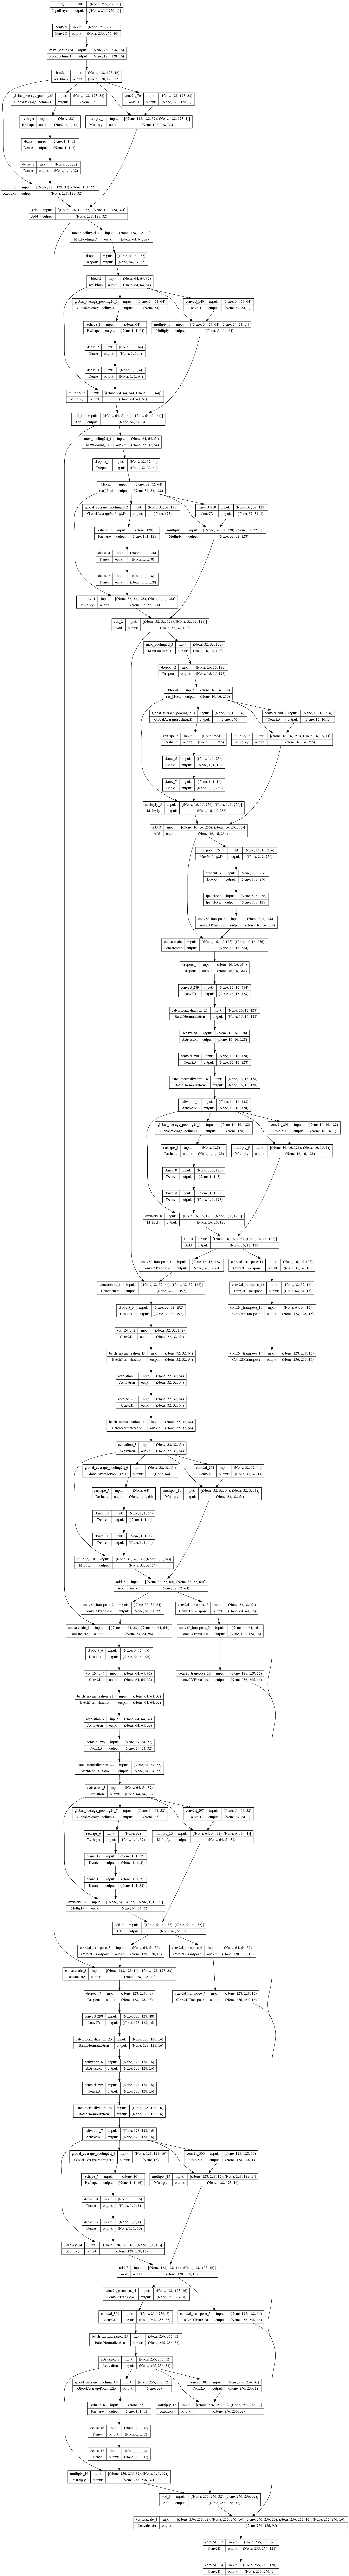

In [7]:
tf.keras.utils.plot_model(model,show_shapes=True)

# Training with Binary Cross Entropy as loss

In [13]:
model.fit(train_dataloader,epochs=50,steps_per_epoch=len(train_dataloader)//10,validation_data=val_dataloader,callbacks=[tensorboard_callback,percent_5_decrease,save_model])

Epoch 1/50
Instructions for updating:
Use fn_output_signature instead
36/36 [==============================] - ETA: 0s - loss: 0.3889 - Kaggle_IoU_Precision: 0.2264 - binary_io_u: 0.4319 - accuracy: 0.8318
Epoch 1: loss improved from inf to 0.38893, saving model to weightsRESNXT34.h5
36/36 [==============================] - 77s 1s/step - loss: 0.3889 - Kaggle_IoU_Precision: 0.2264 - binary_io_u: 0.4319 - accuracy: 0.8318 - val_loss: 0.4375 - val_Kaggle_IoU_Precision: 0.3600 - val_binary_io_u: 0.4197 - val_accuracy: 0.8394 - lr: 9.5500e-04
Epoch 2/50
36/36 [==============================] - ETA: 0s - loss: 0.3412 - Kaggle_IoU_Precision: 0.2658 - binary_io_u: 0.4945 - accuracy: 0.8470
Epoch 2: loss improved from 0.38893 to 0.34123, saving model to weightsRESNXT34.h5
36/36 [==============================] - 34s 962ms/step - loss: 0.3412 - Kaggle_IoU_Precision: 0.2658 - binary_io_u: 0.4945 - accuracy: 0.8470 - val_loss: 0.3545 - val_Kaggle_IoU_Precision: 0.0175 - val_binary_io_u: 0.4204 - 

In [23]:
model.fit(train_dataloader,epochs=50,steps_per_epoch=len(train_dataloader)//10,validation_data=val_dataloader,callbacks=[tensorboard_callback,percent_5_decrease,save_model])

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


36/36 [==============================] - ETA: 0s - loss: 0.1986 - Kaggle_IoU_Precision: 0.5056 - binary_io_u: 0.7391 - accuracy: 0.9196
Epoch 1: loss improved from inf to 0.19862, saving model to weightsRESNXT34.h5
36/36 [==============================] - 121s 3s/step - loss: 0.1986 - Kaggle_IoU_Precision: 0.5056 - binary_io_u: 0.7391 - accuracy: 0.9196 - val_loss: 1.0040 - val_Kaggle_IoU_Precision: 0.3463 - val_binary_io_u: 0.4274 - val_accuracy: 0.6295 - lr: 9.5500e-04
Epoch 2/50
36/36 [==============================] - ETA: 0s - loss: 0.1662 - Kaggle_IoU_Precision: 0.5522 - binary_io_u: 0.7679 - accuracy: 0.9358
Epoch 2: loss improved from 0.19862 to 0.16620, saving model to weightsRESNXT34.h5
36/36 [==============================] - 76s 2s/step - loss: 0.1662 - Kaggle_IoU_Precision: 0.5522 - binary_io_u: 0.7679 - accuracy: 0.9358 - val_loss: 0.8790 - val_Kaggle_IoU_Precision: 0.3373 - val_binary_io_u: 0.4481 - val_accuracy: 0.6543 - lr: 9.1203e-04
Epoch 3/50
36/36 [================

In [ ]:
model.fit(train_dataloader,initial_epoch=50,epochs=100,steps_per_epoch=len(train_dataloader)//10,validation_data=val_dataloader,callbacks=[tensorboard_callback,percent_5_decrease,save_model])

Epoch 51/100
36/36 [==============================] - ETA: 0s - loss: 41.0371 - Kaggle_IoU_Precision: 0.5600 - binary_io_u: 0.7775 - accuracy: 0.9179
Epoch 51: val_loss did not improve from 0.12616
36/36 [==============================] - 26s 469ms/step - loss: 41.0371 - Kaggle_IoU_Precision: 0.5600 - binary_io_u: 0.7775 - accuracy: 0.9179 - val_loss: 72.2574 - val_Kaggle_IoU_Precision: 0.3605 - val_binary_io_u: 0.3950 - val_accuracy: 0.5946 - lr: 9.5500e-04
Epoch 52/100
36/36 [==============================] - ETA: 0s - loss: 40.7281 - Kaggle_IoU_Precision: 0.5583 - binary_io_u: 0.7146 - accuracy: 0.9151
Epoch 52: val_loss did not improve from 0.12616
36/36 [==============================] - 16s 432ms/step - loss: 40.7281 - Kaggle_IoU_Precision: 0.5583 - binary_io_u: 0.7146 - accuracy: 0.9151 - val_loss: 74.4279 - val_Kaggle_IoU_Precision: 0.3490 - val_binary_io_u: 0.3546 - val_accuracy: 0.5438 - lr: 9.1203e-04
Epoch 53/100
36/36 [==============================] - ETA: 0s - loss: 40.8

In [14]:
model.fit(train_dataloader,initial_epoch=50,epochs=100,steps_per_epoch=len(train_dataloader)//10,validation_data=val_dataloader,callbacks=[tensorboard_callback,percent_5_decrease,save_model])

Epoch 51/100
Instructions for updating:
Use fn_output_signature instead
36/36 [==============================] - ETA: 0s - loss: 30.5738 - Kaggle_IoU_Precision: 0.6417 - binary_io_u: 0.7665 - accuracy: 0.9346
Epoch 51: val_loss improved from inf to 34.29072, saving model to ep051-val_loss34.291.h5
36/36 [==============================] - 39s 475ms/step - loss: 30.5738 - Kaggle_IoU_Precision: 0.6417 - binary_io_u: 0.7665 - accuracy: 0.9346 - val_loss: 34.2907 - val_Kaggle_IoU_Precision: 0.6260 - val_binary_io_u: 0.7546 - val_accuracy: 0.9294 - lr: 9.5500e-04
Epoch 52/100
36/36 [==============================] - ETA: 0s - loss: 34.3200 - Kaggle_IoU_Precision: 0.6039 - binary_io_u: 0.7770 - accuracy: 0.9333
Epoch 52: val_loss did not improve from 34.29072
36/36 [==============================] - 15s 409ms/step - loss: 34.3200 - Kaggle_IoU_Precision: 0.6039 - binary_io_u: 0.7770 - accuracy: 0.9333 - val_loss: 39.9546 - val_Kaggle_IoU_Precision: 0.5800 - val_binary_io_u: 0.6864 - val_accura

## Training further for 100 epochs, changing loss with Jaccard Loss hasn't resulted in any improvement in Validation losses/iou score/precision. 
Plots given in the folder

Possible Reasons:
- U-Resnet which was used by the first-place winning solution was not developed from scratch by them. It was from a library "classification models" with pretrained "imagenet" weights.
<br> I tried to replicate it but Keras doesn't support the library anymore. I tried using Keras' older version in Colab but the code breaks down due to newer version of dependencies

# MODEL 2: Vanilla U-Net
Binary-Cross Entropy+ Jaccard Loss

(2, 128, 128)
(2, 128, 128)


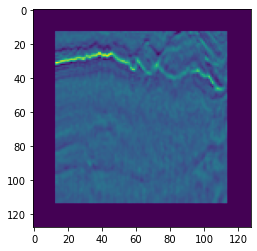

In [14]:
#datagenerator
def random_in_range(lower_limit,upper_limit):
    number=lower_limit+(np.random.rand(1)[0]*(upper_limit-lower_limit))
    return number

#function to change any nonzero value in an array to 1
def clean_mask(arr):
    temp=np.nonzero(arr)
        
    for i in range(temp[0].shape[0]):
        arr[temp[0][i],temp[1][i]]=1
    return arr


class Dataset:
    # the parameters needs to changed based on your requirements
    # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
    # ex: fil_name.jpg   file_name.mask.jpg
    def __init__(self, file_path,mask_path):
        
        self.iids = file_path
        self.mids = mask_path

        # the paths of images
        self.images_fps   = [i for i in self.iids]
        # the paths of segmentation images
        self.masks_fps    = [i for i in self.mids]
        # giving labels for each class

    def __getitem__(self, i):
        
        # read data
        image=cv2.imread(self.images_fps[i],cv2.IMREAD_GRAYSCALE)
        image_mask = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)

        #removed some augmentations after the loss didnt improve
        a = np.random.uniform()
        if a<0.1:
            True
        elif a<0.25:
            aug = iaa.Fliplr(1)
            image,image_mask=aug.augment(images=[image,image_mask])
        elif a<0.4:
            True
            # aug = iaa.Affine(scale={"x": random_in_range(1,1.5), "y":random_in_range(1,1.5)})
            # image,image_mask=aug.augment(images=[image,image_mask])
            
        elif a<0.55:
            aug = iaa.Affine(rotate=random_in_range(0,360))
            image,image_mask=aug.augment(images=[image,image_mask])
            
        elif a<0.70:
            True
            # aug = iaa.Affine(shear=random_in_range(-16,16))
            # image,image_mask=aug.augment(images=[image,image_mask])
            
        elif a<0.85:
            True
            # aug=iaa.PiecewiseAffine(scale=random_in_range(0.01, 0.05))
            # image,image_mask=aug.augment(images=[image,image_mask])

        else:
            aug=iaa.GammaContrast(random_in_range(0.5, 2.0))
            image,image_mask=aug.augment(images=[image,image_mask])
            
        image = cv2.copyMakeBorder(image, 13, 14, 13, 14, cv2.BORDER_CONSTANT,value=[0,0,0])
        image_mask = cv2.copyMakeBorder(image_mask,13, 14, 13, 14, cv2.BORDER_CONSTANT,value=[0,0,0])

        image_mask=clean_mask(image_mask)
        
        return image, image_mask
        
    def __len__(self):
        return len(self.iids)
       
class Test_Dataset:
    # the parameters needs to changed based on your requirements
    # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
    # ex: fil_name.jpg   file_name.mask.jpg
    def __init__(self, file_path,mask_path):
        
        self.iids = file_path
        self.mids = mask_path

        # the paths of images
        self.images_fps   = [i for i in self.iids]
        # the paths of segmentation images
        self.masks_fps    = [i for i in self.mids]
        # giving labels for each class

    def __getitem__(self, i):
        
        # read data
        image=cv2.imread(self.images_fps[i],cv2.IMREAD_GRAYSCALE)
        image_mask = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)

        image = cv2.copyMakeBorder(image, 13, 14, 13, 14, cv2.BORDER_CONSTANT,value=[0,0,0])
        image_mask = cv2.copyMakeBorder(image_mask,13, 14, 13, 14, cv2.BORDER_CONSTANT,value=[0,0,0])
        
        image_mask=clean_mask(image_mask)
        
        return image, image_mask
        
    def __len__(self):
        return len(self.iids)
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

train_dataset = Dataset(train['img_path'],train['mask_path'])
val_dataset = Test_Dataset(validation['img_path'],validation['mask_path'])

train_dataloader = Dataloder(train_dataset, batch_size=2, shuffle=True)
val_dataloader = Dataloder(val_dataset, batch_size=2, shuffle=False)

print(train_dataloader[0][0].shape)
print(val_dataloader[0][0].shape)
plt.imshow(train_dataloader[0][0][0])

In [7]:
# I tried to make it as simple as possible, I think you can understand the architecture just by looking at the code below
def UNet(input_img):

    c1 = Conv2D(16, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(input_img)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    
    c1 = Conv2D(16, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(c1)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(0.1)(p1)
#-----------------------------------------------------------------------------------------------------------------    
    
    c2 = Conv2D(32, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    
    c2 = Conv2D(32, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(c2)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.1)(p2) 
#-----------------------------------------------------------------------------------------------------------------    
    
    c3 = Conv2D(64, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    
    c3 = Conv2D(64, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(c3)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(0.1)(p3) 
    
#-----------------------------------------------------------------------------------------------------------------    
    
    c4 = Conv2D(128, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    
    c4 = Conv2D(128, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(c4)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(0.1)(p4) 
    
#-----------------------------------------------------------------------------------------------------------------    
    
    c5 = Conv2D(256, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)
    
    c5 = Conv2D(256, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(c5)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)
    
#------UMSAMPLE STARTS---------------------------------------------------------------------------------------------

    u6 = Conv2DTranspose(128, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.1)(u6)
    
    c6 = Conv2D(128, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Activation('relu')(c6)
    
    c6 = Conv2D(128, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(c6)
    c6 = BatchNormalization()(c6)
    c6 = Activation('relu')(c6)
    
#---------------------------------------------------------------------------------------------------

    u7 = Conv2DTranspose(64, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.1)(u7)
    
    c7 = Conv2D(64, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)
    
    c7 = Conv2D(64, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(c7)
    c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)
    
#---------------------------------------------------------------------------------------------------

    u8 = Conv2DTranspose(32, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.1)(u8)
    
    c8 = Conv2D(32, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Activation('relu')(c8)

    c8 = Conv2D(32, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(c8)
    c8 = BatchNormalization()(c8)
    c8 = Activation('relu')(c8)
    
#---------------------------------------------------------------------------------------------------

    u9 = Conv2DTranspose(16, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(0.1)(u9)
    
    c9 = Conv2D(16, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Activation('relu')(c9)
    
    c9 = Conv2D(16, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(c9)
    c9 = BatchNormalization()(c9)
    c9 = Activation('relu')(c9)
    
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

 
    
    model = Model(input_img, outputs)
    return model

In [ ]:
input_img = Input((128, 128, 1), name='img')
model = UNet(input_img)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=[iou_score,"accuracy"])

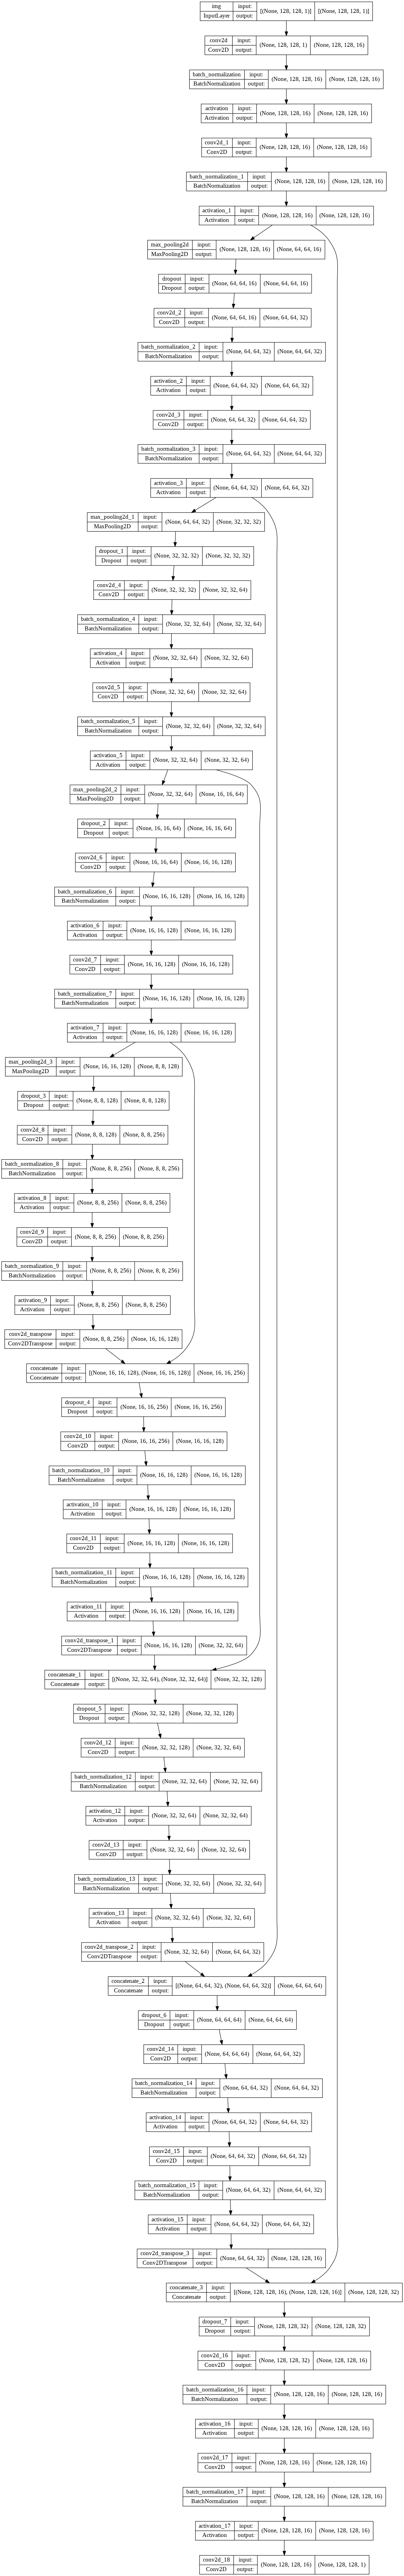

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True)

### Training

400 Epochs with Binary Cross Entropy

In [23]:
model.fit(train_dataloader, epochs=400,steps_per_epoch=len(train_dataloader)//2,callbacks=tensorboard_callback)#validation_data=val_dataloader,steps_per_epoch=len(train_dataloader)//40, epochs=600,callbacks=tensorboard_callback)

Epoch 1/400
900/900 [==============================] - 33s 18ms/step - loss: 0.3478 - binary_io_u: 0.5102 - accuracy: 0.8441
Epoch 2/400
900/900 [==============================] - 17s 18ms/step - loss: 0.2739 - binary_io_u: 0.6336 - accuracy: 0.8864
Epoch 3/400
900/900 [==============================] - 17s 19ms/step - loss: 0.2416 - binary_io_u: 0.6846 - accuracy: 0.9038
Epoch 4/400
900/900 [==============================] - 17s 19ms/step - loss: 0.2230 - binary_io_u: 0.7265 - accuracy: 0.9142
Epoch 5/400
900/900 [==============================] - 16s 18ms/step - loss: 0.2122 - binary_io_u: 0.7222 - accuracy: 0.9195
Epoch 6/400
900/900 [==============================] - 16s 18ms/step - loss: 0.1980 - binary_io_u: 0.7412 - accuracy: 0.9236
Epoch 7/400
900/900 [==============================] - 17s 19ms/step - loss: 0.1985 - binary_io_u: 0.7529 - accuracy: 0.9251
Epoch 8/400
900/900 [==============================] - 16s 18ms/step - loss: 0.1925 - binary_io_u: 0.7564 - accuracy: 0.9270


### Changing Loss to Jaccard_Distance and training for 250 epochs

In [ ]:
def jaccard_distance(y_true, y_pred, smooth=100):
    """ Calculates mean of Jaccard distance as a loss function """
    y_true=tf.cast(y_true,tf.float32)
    # print(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1,2))
    sum_ = tf.reduce_sum(y_true + y_pred, axis=(1,2))
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    jd =  (1 - jac) * smooth
    return tf.reduce_mean(jd)

model.compile(optimizer=Adam(0.0001), loss=jaccard_distance, metrics=[iou_score,"accuracy"])

In [32]:
model.fit(train_dataloader, epochs=50,steps_per_epoch=len(train_dataloader)//2,callbacks=tensorboard_callback)#validation_data=val_dataloader,steps_per_epoch=len(train_dataloader)//40, epochs=600,callbacks=tensorboard_callback)

Epoch 1/50
900/900 [==============================] - 20s 19ms/step - loss: 17.5397 - binary_io_u: 0.9070 - accuracy: 0.9753
Epoch 2/50
900/900 [==============================] - 17s 19ms/step - loss: 14.3315 - binary_io_u: 0.9110 - accuracy: 0.9762
Epoch 3/50
900/900 [==============================] - 18s 20ms/step - loss: 14.0671 - binary_io_u: 0.9185 - accuracy: 0.9775
Epoch 4/50
900/900 [==============================] - 17s 19ms/step - loss: 13.1568 - binary_io_u: 0.9124 - accuracy: 0.9768
Epoch 5/50
900/900 [==============================] - 17s 19ms/step - loss: 13.4220 - binary_io_u: 0.9086 - accuracy: 0.9752
Epoch 6/50
900/900 [==============================] - 17s 19ms/step - loss: 13.3345 - binary_io_u: 0.9240 - accuracy: 0.9804
Epoch 7/50
900/900 [==============================] - 18s 20ms/step - loss: 12.6338 - binary_io_u: 0.9225 - accuracy: 0.9791
Epoch 8/50
900/900 [==============================] - 17s 19ms/step - loss: 12.7838 - binary_io_u: 0.9205 - accuracy: 0.9782


In [34]:
model.fit(train_dataloader, epochs=100,steps_per_epoch=len(train_dataloader)//2,callbacks=tensorboard_callback)#validation_data=val_dataloader,steps_per_epoch=len(train_dataloader)//40, epochs=600,callbacks=tensorboard_callback)

Epoch 1/100
900/900 [==============================] - 19s 20ms/step - loss: 9.9217 - binary_io_u: 0.9411 - accuracy: 0.9840
Epoch 2/100
900/900 [==============================] - 18s 20ms/step - loss: 10.0499 - binary_io_u: 0.9315 - accuracy: 0.9820
Epoch 3/100
900/900 [==============================] - 18s 20ms/step - loss: 10.0591 - binary_io_u: 0.9348 - accuracy: 0.9826
Epoch 4/100
900/900 [==============================] - 18s 20ms/step - loss: 9.7815 - binary_io_u: 0.9427 - accuracy: 0.9853
Epoch 5/100
900/900 [==============================] - 19s 21ms/step - loss: 10.4310 - binary_io_u: 0.9328 - accuracy: 0.9825
Epoch 6/100
900/900 [==============================] - 19s 21ms/step - loss: 10.3794 - binary_io_u: 0.9349 - accuracy: 0.9826
Epoch 7/100
900/900 [==============================] - 18s 21ms/step - loss: 11.1873 - binary_io_u: 0.9299 - accuracy: 0.9814
Epoch 8/100
900/900 [==============================] - 18s 20ms/step - loss: 10.5792 - binary_io_u: 0.9329 - accuracy: 0

In [38]:
model.fit(train_dataloader, epochs=100,steps_per_epoch=len(train_dataloader)//2,validation_data=val_dataloader,callbacks=[tensorboard_callback,ReduceLROnPlateau(monitor="val_loss",   factor=0.1,patience=3,mode="auto",cooldown=0)])#validation_data=val_dataloader,steps_per_epoch=len(train_dataloader)//40, epochs=600,callbacks=tensorboard_callback)

Epoch 1/100
900/900 [==============================] - 25s 28ms/step - loss: 9.2304 - binary_io_u: 0.9475 - accuracy: 0.9860 - val_loss: 15.1207 - val_binary_io_u: 0.8953 - val_accuracy: 0.9716 - lr: 1.0000e-04
Epoch 2/100
900/900 [==============================] - 23s 26ms/step - loss: 9.4199 - binary_io_u: 0.9363 - accuracy: 0.9836 - val_loss: 15.3368 - val_binary_io_u: 0.8822 - val_accuracy: 0.9681 - lr: 1.0000e-04
Epoch 3/100
900/900 [==============================] - 20s 23ms/step - loss: 8.6589 - binary_io_u: 0.9427 - accuracy: 0.9849 - val_loss: 14.6611 - val_binary_io_u: 0.8897 - val_accuracy: 0.9702 - lr: 1.0000e-04
Epoch 4/100
900/900 [==============================] - 19s 21ms/step - loss: 8.0256 - binary_io_u: 0.9537 - accuracy: 0.9879 - val_loss: 15.4876 - val_binary_io_u: 0.8852 - val_accuracy: 0.9689 - lr: 1.0000e-04
Epoch 5/100
900/900 [==============================] - 19s 22ms/step - loss: 8.7449 - binary_io_u: 0.9494 - accuracy: 0.9864 - val_loss: 14.4660 - val_binar

In [39]:
model.save("model3.h5")

# Visualizing Results

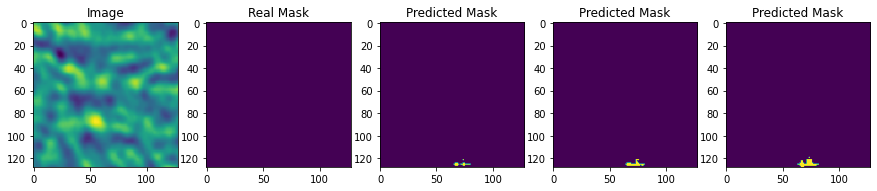

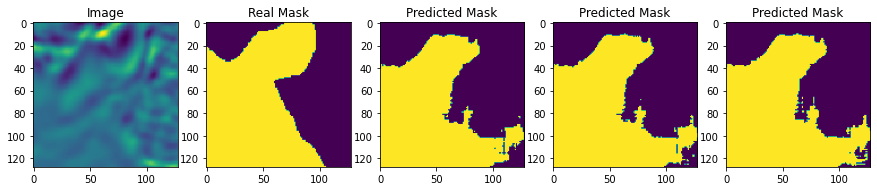

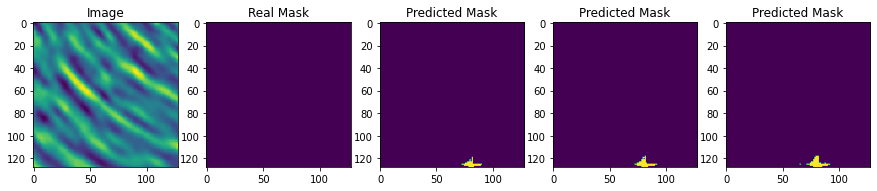

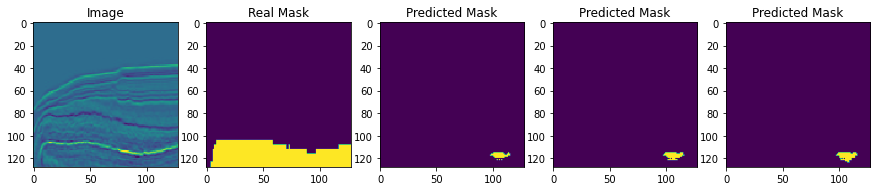

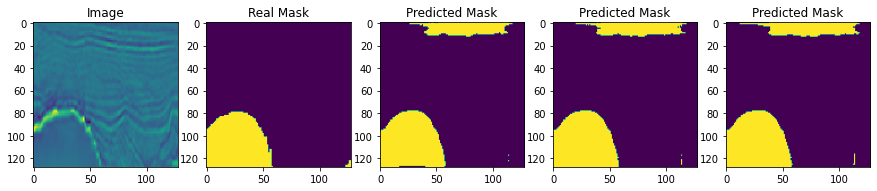

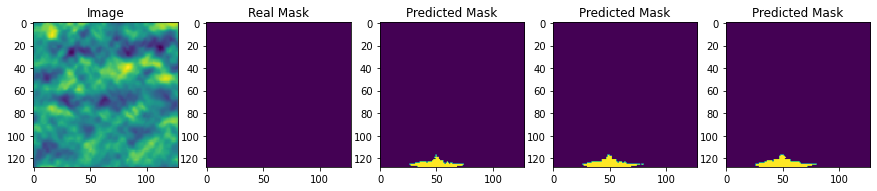

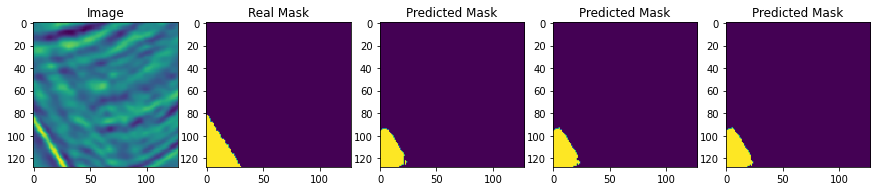

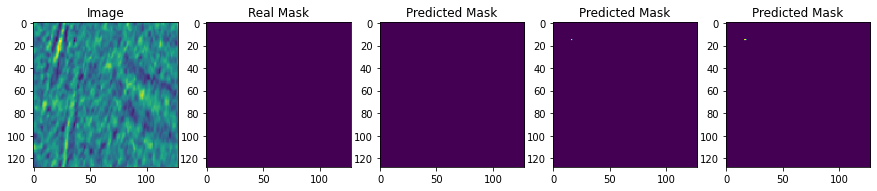

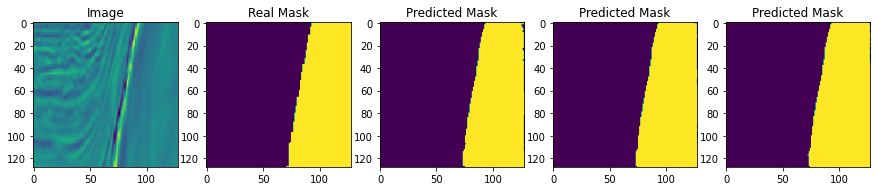

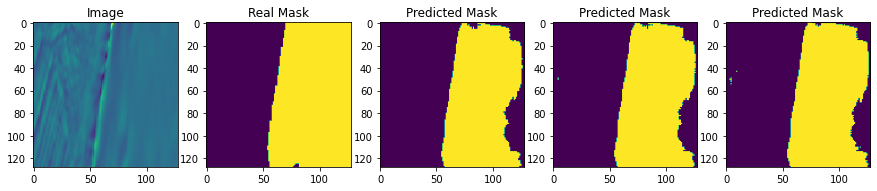

In [40]:
def pred_image(arr,threshold=0.5):
    res=np.zeros((arr.shape[0],arr.shape[1],arr.shape[2]))
    for i,j in enumerate(arr):
        final_image=j[:,:,0]
        final_image=prob_to_image(final_image,threshold=threshold)
        res[i]=final_image
    return res
def prob_to_image(arr,threshold=0.5):
    for i in range(128):
        for j in range(128):
            if arr[i,j]>threshold:
                arr[i,j]=1
            else:
                arr[i,j]=0
    return arr
for i in range(10):
    plt.figure(figsize=(15,15))
    x=np.random.randint(4000)
    z=cv2.imread(data["img_path"][x],cv2.IMREAD_GRAYSCALE)
    z = cv2.resize(z,(128,128),interpolation=cv2.INTER_NEAREST)
    plt.subplot(1,5,1)
    plt.title("Image")
    plt.imshow(z)
    plt.subplot(1,5,2)
    plt.title("Real Mask")
    z=cv2.imread(data["mask_path"][x],cv2.IMREAD_GRAYSCALE)
    z = cv2.resize(z,(128,128),interpolation=cv2.INTER_NEAREST)
    plt.imshow(z)
    plt.subplot(1,5,3)
    plt.title("Predicted Mask")
    plt.imshow(pred_image(model.predict(np.expand_dims(cv2.resize(cv2.imread(data["img_path"][x],cv2.IMREAD_GRAYSCALE),(128,128),interpolation=cv2.INTER_NEAREST),0)),threshold=0.75)[0])
    plt.subplot(1,5,4)
    plt.title("Predicted Mask")
    plt.imshow(pred_image(model.predict(np.expand_dims(cv2.resize(cv2.imread(data["img_path"][x],cv2.IMREAD_GRAYSCALE),(128,128),interpolation=cv2.INTER_NEAREST),0)),threshold=0.5)[0])
    plt.subplot(1,5,5)
    plt.title("Predicted Mask")
    plt.imshow(pred_image(model.predict(np.expand_dims(cv2.resize(cv2.imread(data["img_path"][x],cv2.IMREAD_GRAYSCALE),(128,128),interpolation=cv2.INTER_NEAREST),0)),threshold=0.25)[0])
    plt.show()

The Three Predicted Masks are for different probability thresholds outputted by model. 0.75,0.5 and 0.25 respectively from Left to Right

Predicting for Test Data

In [42]:
import os

listt=os.listdir("test/images")
def pred_image(arr,threshold=0.5):
    res=np.zeros((arr.shape[0],arr.shape[1],arr.shape[2]))
    for i,j in enumerate(arr):
        final_image=j[:,:,0]
        final_image=prob_to_image(final_image,threshold=threshold)
        res[i]=final_image
    return res
def prob_to_image(arr,threshold=0.5):
    for i in range(len(arr)):
        for j in range(len(arr)):
            if arr[i,j]>threshold:
                arr[i,j]=1
            else:
                arr[i,j]=0
    return arr
from tqdm import tqdm
def mask_to_rle(arr):
    arr=arr/np.max(arr)
    pos_pixels=[]
    count=1
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            if arr[j,i]==1:
                pos_pixels.append(count)
            count+=1
    if len(pos_pixels)==0:
        return ""
    rle=""
    is_cons=[False]
    for i in range(len(pos_pixels)-1):
        if pos_pixels[i+1]-pos_pixels[i]==1:
            is_cons.append(True)
        else:
            is_cons.append(False)
    count=1
    for i in range(len(pos_pixels)):
        if is_cons[i]==False:
            rle+=" "+str(count)+" "+str(pos_pixels[i])
            count=1
        elif is_cons[i]==True:
            count+=1
    rle+=" "+str(count)
    return rle[3:]

idd=[]
rle=[]
for i in tqdm(listt):
    idd.append(i[:10])
    image=cv2.imread("test/images/"+i,cv2.IMREAD_GRAYSCALE)
    image = cv2.copyMakeBorder(image, 13, 14, 13, 14, cv2.BORDER_CONSTANT,value=[0,0,0])
    image=model.predict(np.expand_dims(image,0))
    image=image[:,13:114,13:114]
    
    image=pred_image(image,threshold=0.5)[0]
    rle.append(mask_to_rle(image))
    
m=pd.DataFrame()
m["id"]=idd
m["rle_mask"]=rle
m.to_csv("submission_3.csv",index=False)

100%|██████████| 18000/18000 [22:13<00:00, 13.50it/s]


# Submission Score(IOU):
Public score :72916
Private score: 0.76095